# Analysis of Output from Hybrid Approach

In [58]:
# Import the Pandas library
import pandas as pd

# Read in the output data
df = pd.read_csv('../output/output_df.csv',encoding='utf-8',quotechar='"')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21971 entries, 0 to 21970
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   author                       21971 non-null  object 
 1   deterministic_author         8982 non-null   object 
 2   fuzzy_author                 20968 non-null  object 
 3   fuzzy_author_score           21971 non-null  float64
 4   distilbert_author            21971 non-null  object 
 5   distilbert_author_score      21971 non-null  float64
 6   title                        21971 non-null  object 
 7   matched_title_deterministic  21971 non-null  object 
 8   matched_title_fuzzy          21971 non-null  object 
 9   fuzzy_title_score            21971 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.7+ MB


## First impressions

Just looking at the output of the `info()` method, I see that there are 21,971 total rows in the dataframe. Some of the columns do not have data in all of the rows. Specifically, `deterministic_author` and `fuzzy_author` have empty cells. That suggests that the deterministic method is by far the most "conservative" approach, and it looks like the fuzzy matching approach is a distant second in that regard.

In [59]:
df.describe()

,fuzzy_author_score,distilbert_author_score,fuzzy_title_score
count,21971.000000,21971.000000,21971.000000
mean,0.954349,0.822853,0.262818
std,0.208732,0.285260,0.439465
min,0.000000,0.082294,0.000000
25%,1.000000,0.689063,0.000000
50%,1.000000,0.999995,0.000000
75%,1.000000,0.999999,1.000000
max,1.000000,1.000000,1.000000


The `describe()` method only covers two author matching methods, but it tells its own story. The fuzzy matching method appears to be slightly more liberal, with a 86.04% matching average, while the DistilBERT model had an 82.29% average. More revealing is the quartile output, with 25% of the records getting an 85.5% match from the fuzzy method, but the DistilBERT model returned 68.9% at that level. On the other hand, at the 50% mark and above, the DistilBERT model appears to be slightly more confident.

In [3]:
df.head()

,author,deterministic_author,fuzzy_author,fuzzy_author_score,distilbert_author,distilbert_author_score,title,matched_title_deterministic,matched_title_fuzzy,fuzzy_title_score
0,"Du Creux, François, 1596?-1666.",NaN,"{'authorized_name': 'mirk, john, active 1403?'...",0.855,"{'authorized_name': 'cruz, luís da, 1543-1604...",0.467436,"Historiæ canadensis, seu Novæ-Franciæ libri de...",Unknown,Unknown,0.0
1,"Meyer, Ernst H. F. 1791-1858.",NaN,"{'authorized_name': 'vopiscus, flavius', 'auth...",0.855,"{'authorized_name': 'meyer, wilhelm, 1845-1917...",0.999939,Ernesti Meyer de plantis labradoricis libri tres.,Unknown,Unknown,0.0
2,"Laet, Joannes de, 1593-1649.",NaN,"{'authorized_name': 'herryson, joannes', 'auth...",0.855,"{'authorized_name': 'larroumet, gustave', 'aut...",0.494394,"Novus orbis, seu Descriptionis Indiae Occident...",Unknown,Unknown,0.0
3,"Caesar, Julius",NaN,"{'authorized_name': 'caesar, julius', 'author_...",0.960,"{'authorized_name': 'caesar, julius', 'author_...",0.999999,C. Julii Cæsaris commentariorum De Bello Galli...,Unknown,Unknown,0.0
4,Unknown,NaN,NaN,0.000,{'authorized_name': 'stephanus abbas 4. or 6th...,0.177454,Collectanea latina seu ecclesiasticæ antiquita...,Unknown,Unknown,0.0


In [4]:
# Get the number of unique values in the `author` column
df['author'].nunique()

5556

Let's inspect the content of the Greek dataframe.

Those results look pretty solid.

## Deterministic Author Matching

I want to see where this method reported a match.

In [5]:
# Make a dataframe of just the author and deterministic author columns
deterministic = df[['author','deterministic_author']]
# Filter out the NA values
deterministic = deterministic[deterministic['deterministic_author'].notna()]
deterministic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8606 entries, 6 to 21968
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   author                8606 non-null   object
 1   deterministic_author  8606 non-null   object
dtypes: object(2)
memory usage: 201.7+ KB


In [6]:
# Count the number of unique values in the deterministic_author column
print(f"There are {deterministic['deterministic_author'].nunique()} unique authors in the deterministic dataframe.")

There are 432 unique authors in the deterministic dataframe.


There are 432 unique values in the `deterministic_author` column.

I'm going to make a CSV file so that I can investigate the matches more easily. I'll sort the `deterministic` dataframe by the `author` column first, then save the sorted dataframe as a CSV file.

In [7]:
sorted_deterministic = deterministic.sort_values(axis='index',by='author')
sorted_deterministic_deduped = sorted_deterministic.drop_duplicates(subset='author')

In [8]:
import csv
sorted_deterministic_deduped.to_csv('../output/deterministic_author.csv',index=False,quoting=csv.QUOTE_ALL)

As expected, every match achieved by the deterministic method was 100% accurate. On the other hand, it matched only 432 of the 6,018 unique values in the `author` column.

## Fuzzy Author Matching

In [9]:
# Make a dataframe of the fuzzy matching columns and the author column
fuzzy = df[['author','fuzzy_author','fuzzy_author_score']]
# Eliminate any NaN cells
fuzzy = fuzzy[fuzzy['fuzzy_author'].notna()]

fuzzy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20283 entries, 0 to 21969
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   author              20283 non-null  object 
 1   fuzzy_author        20283 non-null  object 
 2   fuzzy_author_score  20283 non-null  float64
dtypes: float64(1), object(2)
memory usage: 633.8+ KB


In [10]:
# Count the number of unique values in the fuzzy_author column
fuzzy['fuzzy_author'].nunique()

1081

The fuzzy matching method returned 1,081 unique values compared to the 6,018 unique values in the `author` column.

Let's see the rows where there isn't a match.

In [11]:
unmatched_fuzzy = df[df['fuzzy_author'].isna()]
# Show the number of unique author values in the unmatched_fuzzy dataframe
display(unmatched_fuzzy['author'].nunique())
# Display the list of unmatched author names
authors_list = unmatched_fuzzy['author'].to_list()
set(authors_list)


374

{'Academia Molshemensis (Francia)',
 'Acidalius, Valens, 1567-1595',
 'Albertini, Hannibal.',
 'Alegambe, Philippo, 1592-1652',
 'Alvisi, Edoardo, 1850-1915.',
 'Amama, Sixtinus, 1593-1629.',
 'Amati, Pasquale,',
 'Andreantonelli, Sebastiano.',
 'Anhalt, Ottocar.',
 'Appendix Vergiliana.',
 'Arngrímur Jónsson, 1568-1648.',
 'Auerbach, Bertrand, 1856-1942',
 'Augenio, Orazio',
 'Augenio, Orazio.',
 'Bar Hebraeus, 1226-1286.',
 'Barbato, Orazio.',
 'Barbosa, Agostinho, 1590-1649.',
 'Barbosa, Enmanuele.',
 'Barrientos, Bartolomé.',
 'Bartoletti, Fabrizio, 1576-1630.',
 'Bartoletti, Fabrizio.',
 'Bayerische Staatsbibliothek.',
 'Bellegni, Caroli.',
 'Bellone, Niccolò.',
 'Belsheim, Johannus Engebretsen, 1829-1909.',
 'Bhartr̥hari.',
 'Biblioteca apostolica vaticana.',
 'Biblioteca medicea laurenziana.',
 'Biblioteca nazionale marciana.',
 'Bibliotheca Palatina (Biblioteca apostolica vaticana)',
 'Bidloo, Govard, 1649-1713.',
 'Biragus, Aloysius.',
 'Biuso, Carmelo.',
 'Bocchi, Achille, 

The list does not contain any Classical authors, and the authors it does include do not look familiar to me, so it is likely that they simply do not yet have records in the DLL's catalog. I'll save them and use VIAF to make authority records for them at a later date.

In [12]:
unmatched_authors_set = set(authors_list)
with open('../output/unmatched_authors_fuzzy.txt', 'w') as file:
    for author in unmatched_authors_set:
        file.write(f"{author}\n")

In [13]:
len(authors_list)

1688

**SAM: Use the authors_list to remove unlikely matches from the distilbert results. Remove the deterministically matched results, too.**

## Distilbert Matching

Let's see how the distilbert author-matching model performed.

In [14]:
distilbert_model = df[['author','distilbert_author','distilbert_author_score']]
# Eliminate any NaN cells
distilbert_model = distilbert_model[distilbert_model['distilbert_author'].notna()]

distilbert_model.info()

# Count the number of unique values in the fuzzy_author column
print(f"There are {distilbert_model['distilbert_author'].nunique()} unique values in the distilbert_model frame.")
print(f"That is {distilbert_model['distilbert_author'].nunique()-fuzzy['fuzzy_author'].nunique()} more than in the fuzzy frame.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21971 entries, 0 to 21970
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   21971 non-null  object 
 1   distilbert_author        21971 non-null  object 
 2   distilbert_author_score  21971 non-null  float64
dtypes: float64(1), object(2)
memory usage: 515.1+ KB
There are 1891 unique values in the distilbert_model frame.
That is 810 more than in the fuzzy frame.


In [15]:
unmatched_distilbert = df[df['distilbert_author'].isna()]
# Show the number of unique author values in the unmatched_distilbert dataframe
print(f"{unmatched_distilbert['author'].nunique()} authors were not matched by the DistilBERT model.")
# Display the list of unmatched author names
authors_list = unmatched_distilbert['author'].to_list()
set(authors_list)

0 authors were not matched by the DistilBERT model.


set()

The DistilBERT model identified a match for all authors it encountered, which almost certainly means that there are many incorrect matches.

I want to look at the metrics for the DistilBERT and Fuzzy Matching methods. I'll make a set of ranges from 75% to 100% confidence and count up the numbers in each range per method.

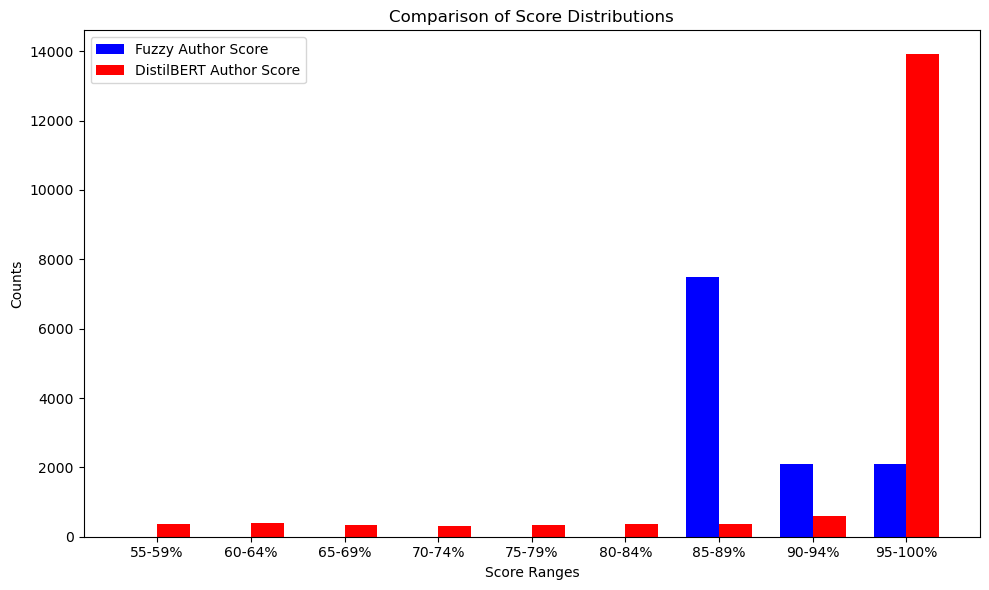

In [16]:
# Visualize the differences
import matplotlib.pyplot as plt
import numpy as np  # Ensure this import is present for array operations

# Assuming 'df' is your original DataFrame with the metrics
bins = [54, 59, 64, 69, 74, 79, 84, 89, 94, 100]
labels = ['55-59%', '60-64%', '65-69%', '70-74%', '75-79%', '80-84%', '85-89%', '90-94%', '95-100%']

metrics = df.copy()
metrics['distilbert_author_score'] = (metrics['distilbert_author_score'] * 100).astype(int)
metrics['fuzzy_author_score'] = (metrics['fuzzy_author_score'] * 100).astype(int)

# Initialize an empty DataFrame with labels as index
comparison_df = pd.DataFrame(index=labels)

# Apply pd.cut and calculate value counts, then add to comparison_df
for metric in ['fuzzy_author_score', 'distilbert_author_score']:
    metrics[f'{metric}_range'] = pd.cut(metrics[metric], bins=bins, labels=labels, right=False)
    comparison_df[metric] = metrics[f'{metric}_range'].value_counts().reindex(labels, fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(labels))

bar1 = plt.bar(index, comparison_df['fuzzy_author_score'], bar_width, label='Fuzzy Author Score', color='blue')
bar2 = plt.bar(index + bar_width, comparison_df['distilbert_author_score'], bar_width, label='DistilBERT Author Score', color='red')

plt.xlabel('Score Ranges')
plt.ylabel('Counts')
plt.title('Comparison of Score Distributions')
plt.xticks(index + bar_width / 2, labels)
plt.legend()

plt.tight_layout()
plt.show()

That's interesting! The fuzzy matching cuts out at 85%, but DistilBERT keeps going, albeit with lower numbers in those ranks. The DistilBERT model also has much higher numbers at the highest confidence rating. That said, DistilBERT is still putting > 300 items into each rank below 90%:

In [17]:
# Applying pd.cut and counting values for each metric
for metric in ['fuzzy_author_score', 'distilbert_author_score']:
    metrics[f'{metric}_range'] = pd.cut(metrics[metric], bins=bins, labels=labels, right=False)
    print(f"Counts for {metric}:")
    print(metrics[f'{metric}_range'].value_counts().sort_index())
    print("\n")

Counts for fuzzy_author_score:
fuzzy_author_score_range
55-59%        0
60-64%        0
65-69%        0
70-74%        0
75-79%        0
80-84%        1
85-89%     7494
90-94%     2093
95-100%    2089
Name: count, dtype: int64


Counts for distilbert_author_score:
distilbert_author_score_range
55-59%       357
60-64%       394
65-69%       334
70-74%       302
75-79%       332
80-84%       366
85-89%       373
90-94%       588
95-100%    13907
Name: count, dtype: int64




I want to take a closer look at the DistilBERT model's matches in each range.

In [43]:
db_95_100 = metrics[metrics['distilbert_author_score_range'] == "95-100%"]
db_95_100 = db_95_100[['author','distilbert_author']]
grouped = db_95_100.groupby(['author','distilbert_author']).value_counts().to_frame().reset_index()
grouped.to_csv('../output/grouped_distilbert_author_matches.csv',index=False,encoding='utf-8',quoting=csv.QUOTE_ALL)

In [44]:
grouped

,author,distilbert_author,count
0,"Abbo, Monk of St. Germain, approximately 850-a...","{'authorized_name': 'abbo, monk of st. germain...",1
1,"Abelard, Peter, 1079-1142.","{'authorized_name': 'abelard, peter', 'author_...",2
2,"Acosta, Jose de, 1540-1600.","{'authorized_name': 'acosta, josé de, 1540-16...",1
3,"Acosta, José de, 1540-1600,","{'authorized_name': 'acosta, josé de, 1540-16...",1
4,"Acosta, José de, 1540-1600.","{'authorized_name': 'acosta, josé de, 1540-16...",4
...,...,...,...
2264,"Zumpt, A. W. 1815-1877.","{'authorized_name': 'zumpt, a. w. (august wilh...",2
2265,"Zwingli, Ulrich 1484-1531.","{'authorized_name': 'zwingli, ulrich, 1484-153...",2
2266,"Zwingli, Ulrich, 1484-1531.","{'authorized_name': 'zwingli, ulrich, 1484-153...",11
2267,"Ḥillī, Ṣafī al-Dīn ʻAbd al-ʻAzīz ibn Sarāyā, 1...","{'authorized_name': 'avicenna, 980-1037', 'aut...",1


In [45]:
# Use the `normalize_author_name()` utility function to lower the `author` value and remove punctuation.
import utilities as utilities
db_95_100['stripped_author'] = db_95_100['author'].apply(lambda x: utilities.normalize_author_name(x))

import ast
db_95_100['distil_author_only'] = db_95_100['distilbert_author'].apply(lambda x: ast.literal_eval(x)['authorized_name'] if isinstance(x, str) else x['authorized_name'])
db_95_100['distil_author_only'] = db_95_100['distil_author_only'].apply(lambda x: utilities.normalize_author_name(x))

db_95_100 = db_95_100[['stripped_author','distil_author_only']]




In [46]:
unique_authors = db_95_100.drop_duplicates(subset=['stripped_author','distil_author_only'])
unique_authors

,stripped_author,distil_author_only
1,meyer ernst h f 17911858,meyer wilhelm 18451917
3,caesar julius,caesar julius
5,drexel jeremias 15811638,drepanius florus 5th century
6,kircher athanasius 16021680,kircher athanasius 16021680
11,hincmar archbishop of reims approximately 806882,hincmar archbishop of reims
...,...,...
21470,arntzenius hendrik jan 17351797,arntzenius johannes 17021759
21499,klotz christian adolph 17381771,klotz alfred 18741956
21697,ibn arabshah ahmad ibn muhammad 13921450,avicenna 9801037
21838,buchanan david 15951652,buchanan george


I'll use the `partial_token_set_ratio` method from the rapidfuzz package to compare the two values in each row.

In [47]:
from rapidfuzz import fuzz, process

unique_authors.loc[:,'partial_token_set'] = [
    fuzz.partial_token_set_ratio(a, b)
    for a, b in zip(unique_authors['stripped_author'], unique_authors['distil_author_only'])
]

unique_authors.loc[:,'token_set'] = [
    fuzz.token_set_ratio(a, b)
    for a, b in zip(unique_authors['stripped_author'], unique_authors['distil_author_only'])
]

unique_authors.loc[:,'token_sort'] = [
    fuzz.token_sort_ratio(a, b)
    for a, b in zip(unique_authors['stripped_author'], unique_authors['distil_author_only'])
]

unique_authors.to_csv('../output/unique_authors_fuzzy_scores.csv',index=False,encoding='utf-8',quoting=csv.QUOTE_ALL)

/var/folders/73/ldt1v6c15m52k8nzfbwmbvg00000gn/T/ipykernel_3439/870449270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_authors.loc[:,'partial_token_set'] = [
/var/folders/73/ldt1v6c15m52k8nzfbwmbvg00000gn/T/ipykernel_3439/870449270.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_authors.loc[:,'token_set'] = [
/var/folders/73/ldt1v6c15m52k8nzfbwmbvg00000gn/T/ipykernel_3439/870449270.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [51]:
unique_authors = pd.read_csv('../output/unique_authors_fuzzy_scores.csv')

In [52]:
unique_authors['std'] = unique_authors.std(axis=1, numeric_only=True)

In [53]:
unique_authors

,stripped_author,distil_author_only,partial_token_set,token_set,token_sort,std
0,kraemer augustus,institoris heinrich 14301505,25.000000,13.636364,13.636364,6.560799
1,tydeman h w 17781863,ticonius,25.000000,14.285714,14.285714,6.185896
2,du buisson petro daniele,bunte bernhard 18211898,27.777778,25.531915,25.531915,1.296650
3,zuffi giovanni,matthaeus zuppardus ca 1430,28.571429,19.512195,19.512195,5.230351
4,budapest hungary magyar nemzeti museum szechen...,istvanffy miklos 15381615,28.571429,21.428571,21.428571,4.123930
...,...,...,...,...,...,...
1868,ritschl friedrich wilhelm 18061876,ritschl friedrich wilhelm 18061876,100.000000,100.000000,100.000000,0.000000
1869,foerster richard 18431922,foerster richard 18431922,100.000000,100.000000,100.000000,0.000000
1870,aurelius victor sextus,victor sextus aurelius,100.000000,100.000000,100.000000,0.000000
1871,holder alfred 18401916,holder alfred 18401916,100.000000,100.000000,100.000000,0.000000


In [57]:
# Assuming 'df' is your original DataFrame with the metrics
bins = [0,1,2,3,4,5,6]
labels = [0,1,2,3,4,5]
# Applying pd.cut and counting values for each metric
for metric in ['std']:
    unique_authors[f'{metric}_range'] = pd.cut(unique_authors[metric], bins=bins, labels=labels, right=False)
    print(f"Counts for {metric}:")
    print(unique_authors[f'{metric}_range'].value_counts().sort_index())
    print("\n")

Counts for std:
std_range
0    441
1     77
2     72
3     85
4     86
5     83
Name: count, dtype: int64




## What about Titles?

This is where the automation really matters. If it can't handle titles accurately, it hasn't really saved much time, since titles take by far that longest amount of time to reconcile manually.

This is where the approach might need adjustment. Specifically, I need to consider using the DistilBERT matching score as the trigger for narrowing down the potential titles to be matched.

In [21]:
title_df = df[['author','title','deterministic_title', 'fuzzy_author','fuzzy_title','fuzzy_title_score']]

KeyError: "['deterministic_title', 'fuzzy_title'] not in index"

In [23]:
title_df

,author,title,deterministic_title,fuzzy_author,fuzzy_title,fuzzy_title_score
0,"Du Creux, François, 1596?-1666.","Historiæ canadensis, seu Novæ-Franciæ libri de...",NaN,"{'authorized_name': 'mirk, john, active 1403?'...","{'dll_id_work': 'W10626', 'dll_id_author': 'A5...",0.855
1,"Meyer, Ernst H. F. 1791-1858.",Ernesti Meyer de plantis labradoricis libri tres.,NaN,"{'authorized_name': 'vopiscus, flavius', 'auth...","{'dll_id_work': 'W4469', 'dll_id_author': 'A49...",0.855
2,"Laet, Joannes de, 1593-1649.","Novus orbis, seu Descriptionis Indiae Occident...",NaN,"{'authorized_name': 'herryson, joannes', 'auth...","{'dll_id_work': 'W10655', 'dll_id_author': 'A3...",0.855
3,"Caesar, Julius",C. Julii Cæsaris commentariorum De Bello Galli...,NaN,"{'authorized_name': 'caesar, julius', 'author_...","{'dll_id_work': 'W5389', 'dll_id_author': 'A33...",0.855
4,Unknown,Collectanea latina seu ecclesiasticæ antiquita...,NaN,NaN,"{'dll_id_work': 'W10631', 'dll_id_author': 'A3...",0.855
...,...,...,...,...,...,...
21966,"Neumann, Karl Johannes, 1857-",Prolegomena in Juliani imperatoris libros quib...,NaN,"{'authorized_name': 'strecker, karl, 1861-1945...","{'dll_id_work': 'W5389', 'dll_id_author': 'A33...",0.855
21967,Unknown,Cvlex carmen Vergilio ascriptvm; recensvit et ...,"{'dll_id_work': 'W356', 'dll_id_author': 'A356...",NaN,"{'dll_id_work': 'W10655', 'dll_id_author': 'A3...",0.855
21968,Persius.,A. Persii flacci Satirarum liber Ex recensione...,NaN,"{'authorized_name': 'persius', 'author_id': 'A...","{'dll_id_work': 'W10636', 'dll_id_author': 'A4...",0.855
21969,"Jaʻfarī, Ṣāliḥ ibn al-Ḥusayn, d. 1269 or ...",Liber decem quaestionum contra Christianos auc...,NaN,"{'authorized_name': 'anaritius, -approximately...","{'dll_id_work': 'W10655', 'dll_id_author': 'A3...",0.855


In [24]:
title_df.to_csv('../data/titles.csv')